In [1]:
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml.clustering import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.classification import *
from pyspark.ml import *
from pyspark.ml import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# pip install openpyxl
import openpyxl

In [2]:
import warnings
warnings.filterwarnings('ignore')

warnings.filterwarnings(action='once')


# Predicting Voter Party Affiliation From Personal Background

## Background

United States presidential campaigns in every state (excluding Maine and Nebraska) use a winner-takes-all system: the candidate who wins the majority of a state's popular vote will win all of that state's electoral votes. For this reason, it is most beneficial for candidates to campaign in swing states, where they are not guaranteed a majority. 

The [Cook Partian Voter Index](https://www.cookpolitical.com/cook-pvi/2022-partisan-voting-index/state-map-and-list) is an independent, non-partisan measurement that uses the two most recent presidential elections to assess how Democratic or Republican a state is compared to the nation as a whole.

According to the CPVI, the most Republican state in 2022 was Wyoming, and the most Democratic state was Vermont.

## Objective

We will examine the largest red and blue states according to the 2022 CPVI, Wyoming and Vermont, respectively. We want to see if we can infer an individual's voter affiliation, their `Party_Description`, from their personal background and lifestyle.

By examining the red and blue states that would be the most 'safe' for a presidential candidate to skip campaigning in, we hope to find aspects of the best voters to target in swing states.

## Loading Data

Let's load our data as parquet files.

The data are collected from the Center for Antiracist Research from Boston University. As they are already tidy, we do not need to do much data cleaning. We simply need to cast features to the correct data type and then examine which features have high amounts of null values. Not all the features were required fields during data collection, as evidenced by the varying rates of nonresponse.

Loading data:

In [3]:
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'

# Wyoming
WY_df_raw = spark.read.parquet(bucket_dir + 'VM2Uniform--WY--2021-01-13')

# Vermont
VT_df_raw = spark.read.parquet(bucket_dir + 'VM2Uniform--VT--2021-05-28')

Casting data types to integers:

In [4]:
VT_df_raw = VT_df_raw.withColumn("Voters_Age", col("Voters_Age").cast("integer"))
VT_df_raw = VT_df_raw.withColumn("CommercialData_AreaMedianEducationYears", 
                               col("CommercialData_AreaMedianEducationYears").cast("integer"))
WY_df_raw = WY_df_raw.withColumn("Voters_Age", col("Voters_Age").cast("integer"))
WY_df_raw = WY_df_raw.withColumn("CommercialData_AreaMedianEducationYears", 
                               col("CommercialData_AreaMedianEducationYears").cast("integer"))


We saved the results of the following code in an xlsx file to save compile time and divided it by the count of all observations in their respective dataframes. This chunk returns each field and their percent null values.

In [5]:
%%script false --no-raise-error
dict_null_VT = {col:VT_df_raw.filter(VT_df_raw[col].isNull()).count() for col in VT_df_raw.columns}
dict_null_WY = {col:WY_df_raw.filter(WY_df_raw[col].isNull()).count() for col in WY_df_raw.columns}


Read back in the files:

In [6]:
VT_null_path = "gs://pstat135-final-project-group-3/notebooks/jupyter/excel-files/VT_nulls.xlsx"

VT_null_df = pd.read_excel(VT_null_path)

/opt/conda/miniconda3/lib/python3.8/site-packages/gcsfs/core.py:519: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.128.15.219', 52622), raddr=('169.254.169.254', 80)>
  self.maybe_refresh()


In [7]:
WY_null_path = "gs://pstat135-final-project-group-3/notebooks/jupyter/excel-files/WY_nulls.xlsx"
WY_null_df = pd.read_excel(WY_null_path)

# Exploratory Data Analysis (EDA)

## Dataframe Dimensions and Schemas

Before starting any statistical analysis of our data, let's first look at the dimensions of our dataframes.

In [8]:
WY_count = WY_df_raw.count()
VT_count = VT_df_raw.count()

print("Number of Rows For Wyoming:     ", WY_df_raw.count(), \
      "\nNumber of Rows For Vermont:       ", VT_df_raw.count(), \
      "\nNumber of Columns For Wyoming:      ", len(WY_df_raw.columns), \
      "\nNumber of Columns For Vermont:    ", len(VT_df_raw.columns)
     )

Number of Rows For Wyoming:          290408 
Number of Rows For Vermont:        463261 
Number of Columns For Wyoming:       726 
Number of Columns For Vermont:     726


For our Wyoming dataframe, we have $548,259$ rows; for Vermont, we have $21,779,518$.

Both have $726$ columns. Confirm the data come from the same source, let's confirm if their schemas are the same:

In [9]:
def schema_diff(schema1, schema2):
    return {
        'Fields in WY and not VT': set(schema1) - set(schema2), \
        'Fields in VT and not WY': set(schema2) - set(schema1)
    }

In [10]:
schema_diff(WY_df_raw.schema, VT_df_raw.schema)

{'Fields in WY and not VT': set(), 'Fields in VT and not WY': set()}

Our sets are both empty, so we've validated that our two schema are identical. Let's take a peek at some of our Vermont data, organized according to ascending percentage of null values:

In [29]:
VT_null_df.head(10)

,field,null_count,null_percent
0,'SEQUENCE',0,0.0
1,'LALVOTERID',0,0.0
2,'Voters_Active',0,0.0
3,'Voters_StateVoterID',0,0.0
4,'Voters_FirstName',0,0.0
5,'Voters_LastName',0,0.0
6,'Residence_Addresses_AddressLine',0,0.0
7,'Residence_Addresses_City',0,0.0
8,'Residence_Addresses_State',0,0.0
9,'Residence_Addresses_StreetName',0,0.0


Some fields, like `Voters_FirstName`, won't be of much use to us. Let's keep looking.

In [34]:
VT_null_df[160:180]

,field,null_count,null_percent
160,'Mailing_Addresses_Zip',450,0.000971
161,'State_House_District',645,0.001392
162,'Residence_Addresses_Latitude',2402,0.005185
163,'Residence_Addresses_Longitude',2402,0.005185
164,'Residence_Addresses_LatLongAccuracy',2402,0.005185
165,'Residence_Addresses_HouseNumber',2522,0.005444
166,'Voters_OfficialRegDate',3127,0.006750
167,'Voters_Age',3498,0.007551
168,'Voters_BirthDate',3498,0.007551
169,'DateConfidence_Description',3498,0.007551


### Feature Selection

Using `Parties_Description` as the response variable, we've set the predictor variables we believe will be of interest as: 
- `Residence_Addresses_City` 
- `Voters_Gender`
- `Voters_Age`
- `CommercialData_DwellingType`
- `CommercialData_ISPSA`
- `Designated_Market_Area_DMA`
- `CommercialData_PropertyType`
- `Community_College`
- `CommercialData_AreaMedianEducationYears`
- `Ethnic_Description`
- `Religions_Description`
- `Languages_Description`
- `Parties_Description`


Let's take a closer look at these fields.

In [35]:
# Wyoming
WY_df = WY_df_raw['Residence_Addresses_City',
               'Voters_Gender',
               'Voters_Age',
               'Ethnic_Description',
               'Religions_Description',
               'CommercialData_AreaMedianEducationYears',
               'Languages_Description',
               'CommercialData_DwellingType',
               'CommercialData_ISPSA',
               'Designated_Market_Area_DMA',
               'CommercialData_PropertyType',
               'Parties_Description']

# Vermont
VT_df = VT_df_raw['Residence_Addresses_City',
               'Voters_Gender',
               'Voters_Age',
               'Ethnic_Description',
               'Religions_Description',
               'CommercialData_AreaMedianEducationYears',
               'Languages_Description',
               'CommercialData_DwellingType',
               'CommercialData_ISPSA',
               'Designated_Market_Area_DMA',
               'CommercialData_PropertyType',
               'Parties_Description']

## Exploratory Data Analysis

Firstly, to understand our response variable `Parties_Description` a little more, we will start by visualizing its distribution.

/opt/conda/miniconda3/lib/python3.8/socket.py:740: ResourceWarning: unclosed <socket.socket fd=70, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 41382), raddr=('127.0.0.1', 43351)>
  self._sock = None


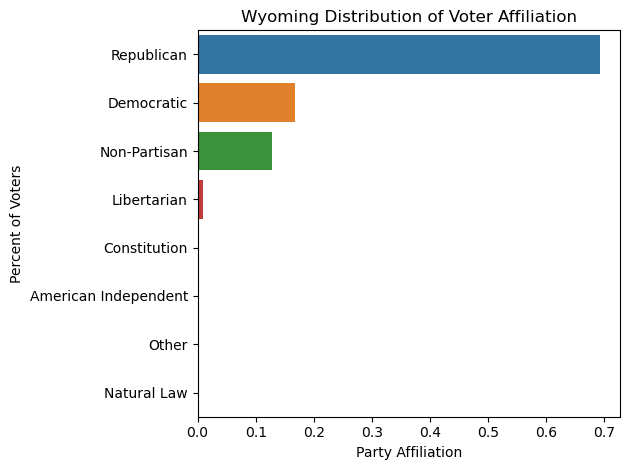

In [12]:
WY_votes_per_party_df = WY_df_raw.groupBy('Parties_Description') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

# percentage scale
WY_votes_per_party_df['Number_Voters'] = WY_votes_per_party_df['Number_Voters']/WY_count

# plot
ax2 = sns.barplot(data = WY_votes_per_party_df, \
            y = 'Parties_Description', \
            x = 'Number_Voters')
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=50, ha="right")
plt.title("Wyoming Distribution of Voter Affiliation")
plt.xlabel("Party Affiliation")
plt.ylabel("Percent of Voters")
plt.tight_layout()
plt.show()

/opt/conda/miniconda3/lib/python3.8/socket.py:740: ResourceWarning: unclosed <socket.socket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 47602), raddr=('127.0.0.1', 43011)>
  self._sock = None


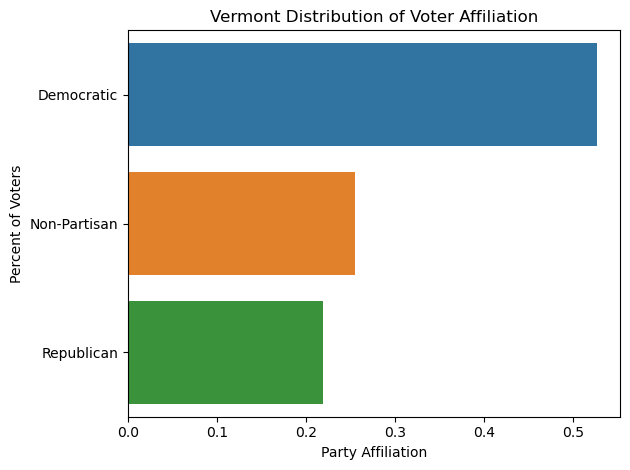

In [13]:
VT_votes_per_party_df = VT_df_raw.groupBy('Parties_Description') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

# percentage scale
VT_votes_per_party_df['Number_Voters'] = VT_votes_per_party_df['Number_Voters']/VT_count 

# plot
ax2 = sns.barplot(data = VT_votes_per_party_df, \
            y = 'Parties_Description', \
            x = 'Number_Voters')
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=50, ha="right")
plt.title("Vermont Distribution of Voter Affiliation")
plt.xlabel("Party Affiliation")
plt.ylabel("Percent of Voters")
plt.tight_layout()
plt.show()

Wyoming is at just under a staggering 70% Republican, while Vermont is at barely over 50% Democrat. Both have a similar proportion of the opposing party. Now let's view the same graphs split by gender:

/opt/conda/miniconda3/lib/python3.8/socket.py:740: ResourceWarning: unclosed <socket.socket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 57774), raddr=('127.0.0.1', 33161)>
  self._sock = None


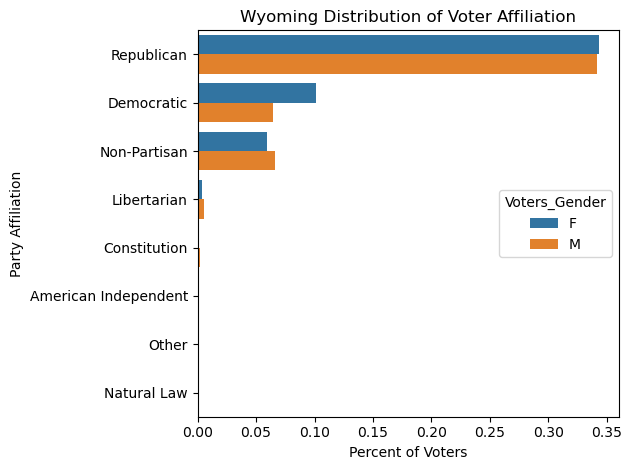

In [14]:
WY_votes_per_party_df = WY_df_raw.groupBy('Parties_Description', 'Voters_Gender') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

# percentage scale
WY_votes_per_party_df['Number_Voters'] = WY_votes_per_party_df['Number_Voters']/WY_count

# plot
ax2 = sns.barplot(data = WY_votes_per_party_df, \
            y = 'Parties_Description', \
            x = 'Number_Voters', \
            hue = 'Voters_Gender')
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=50, ha="right")
plt.title("Wyoming Distribution of Voter Affiliation")
plt.ylabel("Party Affiliation")
plt.xlabel("Percent of Voters")
plt.tight_layout()
plt.show()

/opt/conda/miniconda3/lib/python3.8/socket.py:740: ResourceWarning: unclosed <socket.socket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 38556), raddr=('127.0.0.1', 36075)>
  self._sock = None


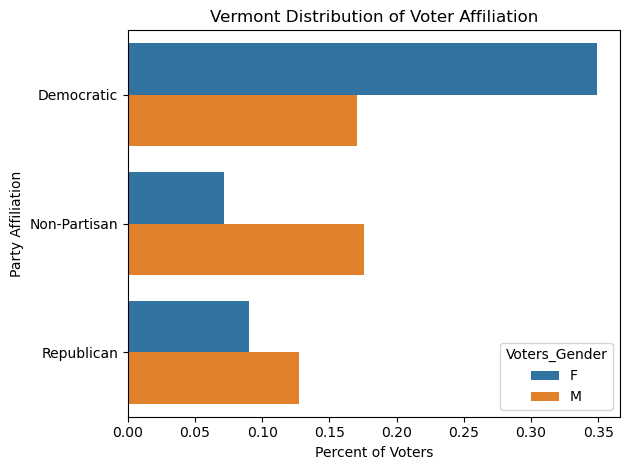

In [15]:
VT_votes_per_party_df = VT_df_raw.groupBy('Parties_Description', 'Voters_Gender') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

# percentage scale
VT_votes_per_party_df['Number_Voters'] = VT_votes_per_party_df['Number_Voters']/VT_count 

# plot
ax2 = sns.barplot(data = VT_votes_per_party_df, \
            y = 'Parties_Description', \
            x = 'Number_Voters', \
                  hue = 'Voters_Gender')
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=50, ha="right")
plt.title("Vermont Distribution of Voter Affiliation")
plt.ylabel("Party Affiliation")
plt.xlabel("Percent of Voters")
plt.tight_layout()
plt.show()

While Wyoming has a relatively even gender split across parties, Vermont has a noticeable difference in the gap between male and female non-partisans and an even larger one between its Democrats.

In [16]:
VT_votes_per_education = VT_df.select('Voters_Age', 
                                      'CommercialData_AreaMedianEducationYears',
                                     'Parties_Description').fillna('None').toPandas()

/opt/conda/miniconda3/lib/python3.8/socket.py:740: ResourceWarning: unclosed <socket.socket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 48832), raddr=('127.0.0.1', 39975)>
  self._sock = None


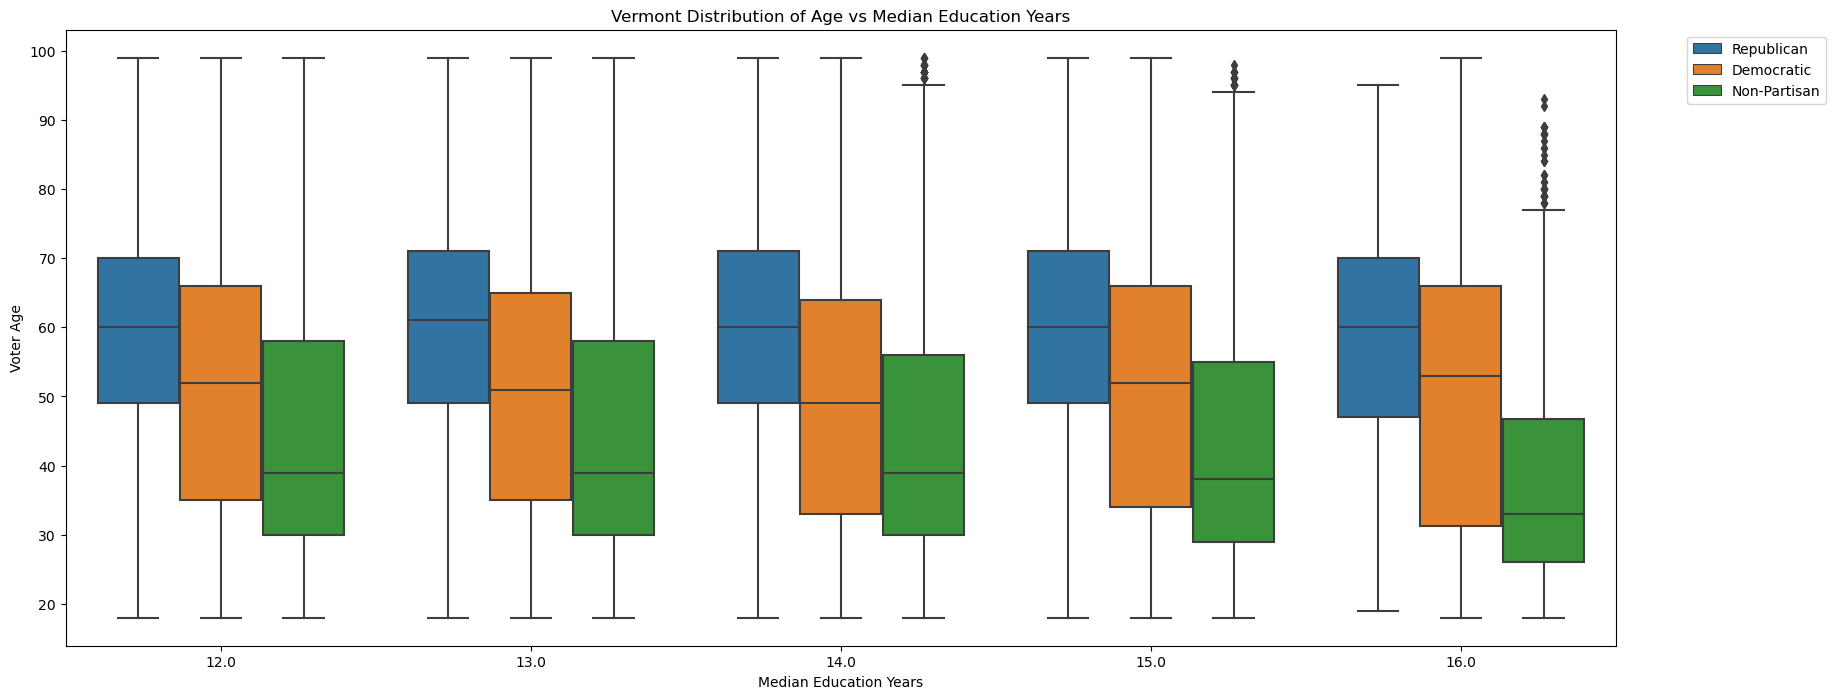

In [17]:
plt.figure(figsize = (20,8))

ax3 = sns.boxplot(x = 'CommercialData_AreaMedianEducationYears',
                     y = 'Voters_Age',
                     hue = "Parties_Description",
                     data = VT_votes_per_education)
plt.xlabel("Median Education Years")
plt.ylabel("Voter Age")
plt.title("Vermont Distribution of Age vs Median Education Years")

plt.legend(bbox_to_anchor = (1.14, 1.0), loc = 'upper right')

Across all median education years, we see fundamental and consistent differences between the three parties' voter ages. Republicans are generally older than Democrats, who are generally older than non-partisan voters. Interestingly enough, the non-partisan voters were the only group to have outliers.

In [18]:
WY_votes_per_education = WY_df.select('Voters_Age', 
                                      'CommercialData_AreaMedianEducationYears',
                                     'Parties_Description').fillna('None').toPandas()

/opt/conda/miniconda3/lib/python3.8/socket.py:740: ResourceWarning: unclosed <socket.socket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 42738), raddr=('127.0.0.1', 43805)>
  self._sock = None


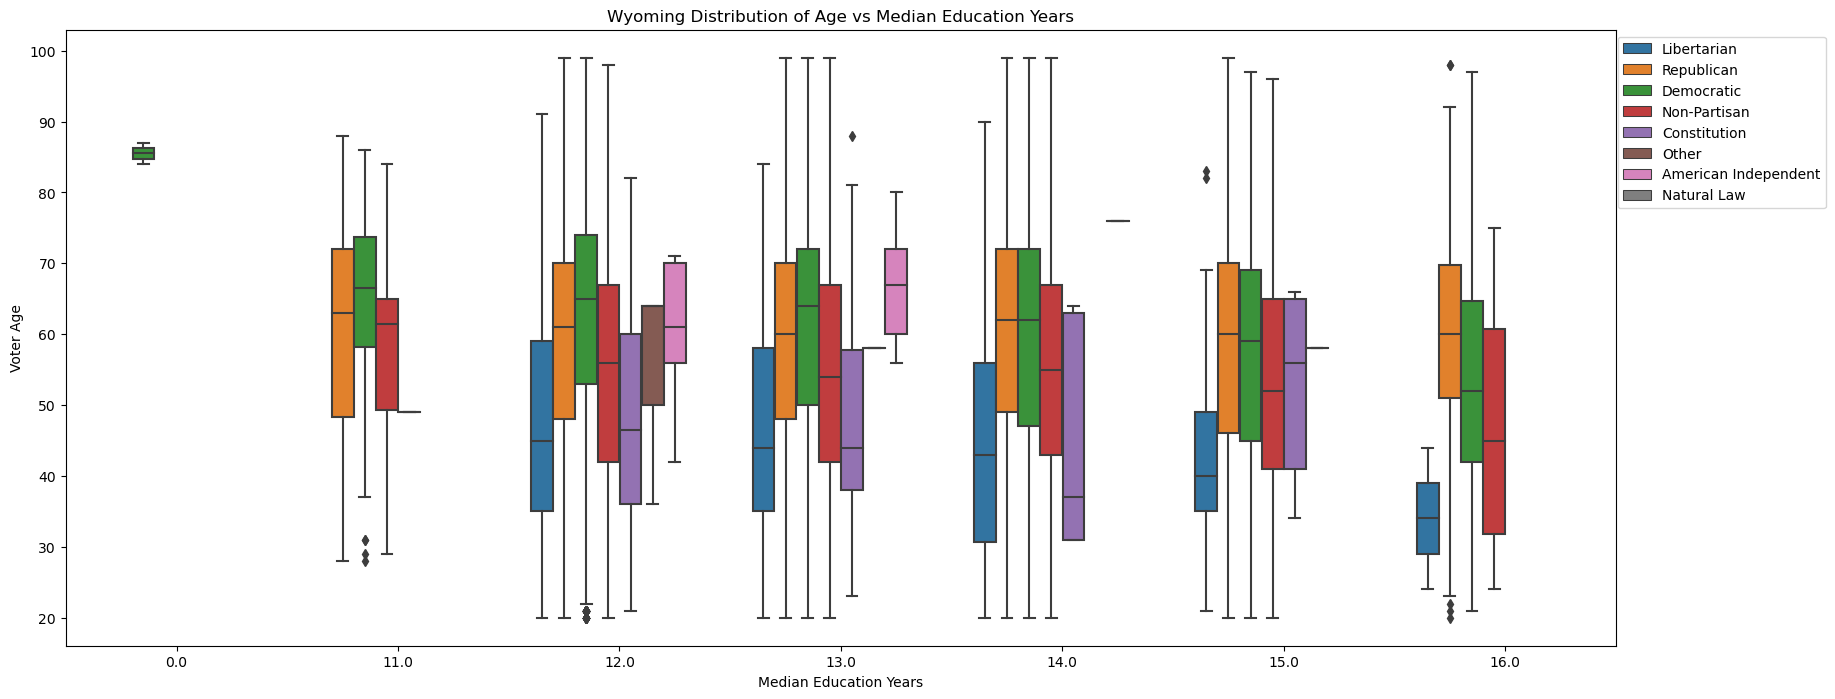

In [19]:
plt.figure(figsize = (20,8))
ax3 = sns.boxplot(x = 'CommercialData_AreaMedianEducationYears',
                     y = 'Voters_Age',
                     hue = "Parties_Description",
                     data = WY_votes_per_education)
plt.xlabel("Median Education Years")
plt.ylabel("Voter Age")
plt.title("Wyoming Distribution of Age vs Median Education Years")
plt.legend(bbox_to_anchor = (1.14, 1.0), loc = 'upper right')

From the above bar plot, we can see that for Libertarians, Republicans, Democrats, and non-partisans that median voter age is generally negatively correlated with median education years. This may simply have to do with increased access to schooling or increasing life span, however.

In [20]:
VT_ethnic_df

NameError: name 'VT_ethnic_df' is not defined

In [ ]:
VT_ethnic_df = VT_df_raw.groupBy('Ethnic_Description') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

WY_ethnic_df = WY_df_raw.groupBy('Ethnic_Description') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()


# percentage scale
VT_ethnic_df['Number_Voters'] = VT_ethnic_df['Number_Voters']/VT_count 
WY_ethnic_df['Number_Voters'] = WY_ethnic_df['Number_Voters']/WY_count  

# plot
fig, (ax4, ax5) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot pie chart for Vermont
ax4.pie(VT_ethnic_df['Number_Voters'], labels=VT_ethnic_df['Ethnic_Description'])
ax4.set_title('VT')

# Plot pie chart for Wyoming
ax5.pie(WY_ethnic_df['Number_Voters'], labels=WY_ethnic_df['Ethnic_Description'])
ax5.set_title('WY')

plt.show()



ax4.set_xticklabels(ax4.get_xticklabels(), rotation=50, ha="right")
plt.title("Vermont Distribution of Ethnicities")
plt.xlabel("Party Affiliation")
plt.ylabel("Percent of Voters")
plt.tight_layout()
plt.show()

Next we'll take a look at religion.

In [ ]:
WY_religion_df = WY_df_raw.groupBy('Religions_Description', 'Voters_Gender') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

# percentage scale
WY_religion_df['Number_Voters'] = WY_religion_df['Number_Voters']/WY_count 

# plot
ax2 = sns.barplot(data = WY_religion_df, \
            y = 'Religions_Description', \
            x = 'Number_Voters', \
                 hue = 'Voters_Gender')
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=50, ha="right")
plt.title("Wyoming Distribution of Religions")
plt.xlabel("Proportion of Voters")
plt.ylabel("Religion")
plt.tight_layout()
plt.show()

In [ ]:
VT_religion_df = VT_df_raw.groupBy('Religions_Description', 'Voters_Gender') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

# percentage scale
VT_religion_df['Number_Voters'] = VT_religion_df['Number_Voters']/VT_count 

# plot
ax2 = sns.barplot(data = VT_religion_df, \
            y = 'Religions_Description', \
            x = 'Number_Voters', \
                 hue = 'Voters_Gender')
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=50, ha="right")
plt.title("Vermont Distribution of Religions")
plt.xlabel("Proportion of Voters")
plt.ylabel("Religion")
plt.tight_layout()
plt.show()

Wyoming and Vermont have roughly similar distributions for each religion, with the major difference being Vermont has twice as many Catholics relative to its total electorate.

Let's explore the distribution of voter age by state.

In [ ]:
# load data and convert to pandas DataFrame
VT_age_pandas_df = VT_df.toPandas()
WY_age_pandas_df = WY_df.toPandas()

# create a new DataFrame with state information
VT_age_pandas_df['State'] = 'Vermont'
WY_age_pandas_df['State'] = 'Wyoming'
combined_df = pd.concat([VT_age_pandas_df, WY_age_pandas_df], ignore_index=True)

# create a FacetGrid and plot the histograms
g = sns.FacetGrid(combined_df, col='State', sharey=False)
g.map(sns.histplot, 'Voters_Age', bins=10)

# set the title and labels
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Distribution of Voter Age By State')
g.set_axis_labels('Age', 'Count')

# rotate x-axis labels
for ax in g.axes.flat:
    ax.tick_params(axis='x')

# show plot
plt.show()

Vermont displays a right-skewed bimodal distribution with far more voters of relatively young age compared to Wyoming. 

In [ ]:
# filter out parties with few counts
WY_party_df = WY_age_pandas_df
WY_party_df = WY_party_df[WY_party_df['Parties_Description'].isin(['Republican', 'Democratic', 'Non-Partisan'])]

# create the FacetGrid
g = sns.FacetGrid(WY_party_df, col='Parties_Description', hue='Parties_Description', height=5)

# create the histogram for each Party
g.map(sns.histplot, 'Voters_Age', bins=10)

# set the title and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Age', 'Count')
g.fig.suptitle('Wyoming Distribution of Age by Party', x = .521, y = 1.06)

# show the plot
plt.show()

In [ ]:
# create the FacetGrid
g = sns.FacetGrid(VT_age_pandas_df, col='Parties_Description', 
                  hue='Parties_Description', height=5)

# create the histogram for each Party
g.map(sns.histplot, 'Voters_Age', bins=15)

# set the title and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Age', 'Count')
g.fig.suptitle('Vermont Distribution of Age by Party', x = .521, y = 1.06)

# show the plot
plt.show()

In fact, we see that both boast distributions in which their dominant party overshadows the others in the aggregated distribution. 

### this plot doesn't work

In [ ]:
VT_language_df = VT_df_raw.groupBy('Languages_Description') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

# percentage scale
VT_language_df['Number_Voters'] = VT_language_df['Number_Voters']/VT_count 

# plot
ax2 = sns.barplot(data = VT_language_df, \
            y = 'Languages_Description', \
            x = 'Number_Voters')
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=50, ha="right")
plt.title("Vermont Distribution of Languages")
plt.xlabel("Proportion of Voters")
plt.ylabel("Language")
plt.tight_layout()
plt.show()

### fix axis labels

Designated market areas, or DMAs, are geographic regions where residents can view the same local TV and radio stations. We think it will be interesting to examine these since individual DMAs may favor certain campaign ads or otherwise generally influence public thinking.

In [ ]:
WY_dma_df = WY_df_raw.groupBy('Designated_Market_Area_DMA') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()
VT_dma_df = VT_df_raw.groupBy('Designated_Market_Area_DMA') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

# Concatenate dataframes and add 'State' column
WY_dma_df['State'] = 'Wyoming'
VT_dma_df['State'] = 'Vermont'
dma_df = pd.concat([WY_dma_df, VT_dma_df])

# percentage scale
dma_df['Number_Voters'] = dma_df['Number_Voters'] / dma_df.groupby('State')['Number_Voters'].transform('sum')

# plot
sns.catplot(data=dma_df, kind='bar', 
            x='Number_Voters', 
            y='Designated_Market_Area_DMA', 
            col='State')
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of DMA in Wyoming and Vermont')
plt.xlabel('Proportion of Voters')
plt.ylabel('DMA')
plt.tight_layout()
plt.show()

The majority of Vermont is under the Burlington/Pittsburg DMA, which may help explain its high concentration of Democratic voters, but Wyoming contains a spread of 7 different zones. We'll have to explore further.

In [ ]:
WY_property_df = WY_df_raw.groupBy('CommercialData_PropertyType') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()
VT_property_df = VT_df_raw.groupBy('CommercialData_PropertyType') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters")) \
    .toPandas()

# Concatenate dataframes and add 'State' column
WY_property_df['State'] = 'Wyoming'
VT_property_df['State'] = 'Vermont'
property_df = pd.concat([WY_property_df, VT_property_df])

# percentage scale
property_df['Number_Voters'] = property_df['Number_Voters'] / property_df.groupby('State')['Number_Voters'].transform('sum')

# plot
sns.catplot(data=property_df, kind='bar', 
            x='Number_Voters', 
            y='CommercialData_PropertyType', 
            col='State')
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Property Types in Wyoming and Vermont')
plt.xlabel('Proportion of Voters')
plt.ylabel('Property Type')
plt.tight_layout()
plt.show()

## Correlations of Response and Predictors

### don't think this will work because we only have 2 numerical features

(ELABORATION OF THIS PROCESS)

In [ ]:
#WY_corr_pandasdf = WY_df.select("Parties_Description", "Residence_Addresses_City", "Voters_Gender", "Voters_Age", "VoterParties_Change_Changed_Party", "Ethnic_Description", \
#                           "Religions_Description", "Languages_Description", "County").toPandas()

In [ ]:
# corrplot = sns.heatmap(WY_corr_pandasdf.corr())
# plt.show()

(COMMENT ON THE RESULTS OF THIS CORRELATION HEATMAP)
(WHAT WE EXPECTED? ARE WE SURPRISED BY ANY CORRELATIONS? SHOULD ANY FEATURE VARIABLES BE DROPPED DUE TO A LACK OF CORRELATION TO OUR PREDICTOR VARIABLE?)

# Final Chosen Dataframe
### are we including this section? note this list isn't updated

Based on the dataframe of null values, here are the features we decided to focus our model building:
- `Residence_Addresses_City`
- `Voters_Gender`
- `Voters_Age`
- `CommercialData_EstimatedHHIncome`
- `Community_College`
- `CommercialData_AreaMedianEducationYears`
- `Ethnic_Description`
- `Religions_Description`
- `Languages_Description`
- `Parties_Description`

(THIS IS THE LAST STEP OF EDA BEFORE MOVING ONTO FEATURE ENGINEERING A.K.A. CREATING NEW FEATURE COLUMNS, TRANSFORMING FEATURE VARIABLES, BINARIZING, ONE-HOT OR DUMMY ENCODING, ETC.)
(THE CODE BELOW IS ONLY A TEMPLATE FOR THE PYSPARK DATAFRAME WE WILL USE FOR THE MODEL BUILDING A.K.A PIPELINE)

WY_final_df = WY_df.select("Parties_Description", "Residence_Addresses_City", "Voters_Gender", "Voters_Age", "VoterParties_Change_Changed_Party", "Ethnic_Description", \
                           "Religions_Description", "Languages_Description", "County")

# Feature Engineering

(FEATURE ENGINEERING A.K.A. CREATING NEW FEATURE COLUMNS, TRANSFORMING FEATURE VARIABLES, BINARIZING, ONE-HOT OR DUMMY ENCODING, ETC.)

# Modeling

As our chosen features are dominated by categorical variables, we decided to run the following models:
- one-vs-rest
- boosted trees
- decision tree

Initializing an empty array to put our results in so that we can see which model did best:

In [ ]:
results = []

## One-Vs-Rest Model for Vermont Parties Description Classification

In [ ]:
VT_df_ovr = VT_df
VT_df_ovr = VT_df_ovr.dropna()
VT_df_ovr.cache()

### String Indexing

We will now encode our columns of strings to columns of indices for our one-vs-rest pipeline.

Getting input and output column names:

In [ ]:
# input columns
input_cols = []
for i in VT_df_ovr.columns:
    input_cols.append(i)


In [ ]:
# output columns
idx_cols = []
for j in input_cols:
    j = j +'_idx'
    idx_cols.append(j)

Apply StringIndexer to our input columns:

In [ ]:
indexer = StringIndexer(inputCols = input_cols, outputCols = idx_cols)
indexer_model = indexer.fit(VT_df_ovr)

Fitting the model to the input dataset:

In [ ]:
VT_df_ovr = indexer_model.transform(VT_df_ovr)
VT_df_ovr = VT_df_ovr.withColumnRenamed("Parties_Description_idx", "label")

Gathering all columns ending in `idx`:

In [ ]:
idx_cols =  []
for i in range(len(VT_df_ovr.columns)):
    if VT_df_ovr.columns[i][-4:] == '_idx':
        idx_cols.append(VT_df_ovr.columns[i])      

Initializing a feature transformer to merge the `idx_cols` into a single vector column:

In [ ]:
assembler = VectorAssembler(inputCols=idx_cols, outputCol='features')
VT_df_ovr = assembler.transform(VT_df_ovr)

### Assembling and training the model:

In [ ]:
(train, test) = VT_df_ovr.randomSplit([0.8, 0.2])
lr = LogisticRegression(featuresCol ='features',maxIter = 10, regParam=0.3, elasticNetParam=0.8)
ovr = OneVsRest(classifier=lr, labelCol = 'label')
ovrModel = ovr.fit(train)

In [ ]:
predictions  = ovrModel.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'accuracy')

evaluator2 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'truePositiveRateByLabel')

evaluator3 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'weightedPrecision')

evaluator4 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'weightedRecall')


In [ ]:
VT_ovr_accuracy = evaluator.evaluate(predictions)

TPRbylabel = evaluator2.evaluate(predictions)

weighted_prec = evaluator3.evaluate(predictions)

weighted_recall = evaluator4.evaluate(predictions) 


In [ ]:
print('Accuracy:', VT_ovr_accuracy,
     '\nTrue positive rate by label:', TPRbylabel,
     '\nWeighted Precision:',weighted_prec,
     '\nWeighted Recall:', weighted_recall)

In [ ]:
results.append(("Vermont one-vs-rest", VT_ovr_accuracy))

### check if below is still correct

We can see here that the true positive rate is quite high, but our accuracy and precision is not very high meaning that our model might be predicting positive too much of the time

## One-vs-rest Logistic Regression

## One-vs-rest: Wyoming

In [ ]:
df_ovr = WY_df
df_ovr = df_ovr.dropna()
df_ovr.cache()

### String Indexing

We will now encode our columns of strings to columns of indices for our one-vs-rest pipeline.

Getting input and output column names:

In [ ]:
# input columns
input_cols = []
for i in df_ovr.columns:
    input_cols.append(i)


In [ ]:
# output columns
idx_cols = []
for j in input_cols:
    j = j +'_idx'
    idx_cols.append(j)

Apply StringIndexer to our input columns:

In [ ]:
indexer = StringIndexer(inputCols = input_cols, outputCols = idx_cols)
indexer_model = indexer.fit(df_ovr)

Fitting the model to the input dataset:

In [ ]:
df_ovr = indexer_model.transform(df_ovr)
df_ovr = df_ovr.withColumnRenamed("Parties_Description_idx", "label")

Gathering all columns ending in `idx`:

In [ ]:
idx_cols =  []
for i in range(len(df_ovr.columns)):
    if df_ovr.columns[i][-4:] == '_idx':
        idx_cols.append(df_ovr.columns[i])      

Initializing a feature transformer to merge the `idx_cols` into a single vector column:

In [ ]:
assembler = VectorAssembler(inputCols=idx_cols, outputCol='features')
df_ovr = assembler.transform(df_ovr)

### Assembling and training the model:

In [ ]:
(train, test) = df_ovr.randomSplit([0.8, 0.2])
lr = LogisticRegression(featuresCol ='features',maxIter = 10, regParam=0.3, elasticNetParam=0.8)
ovr = OneVsRest(classifier=lr, labelCol = 'label')
ovrModel = ovr.fit(train)

In [ ]:
predictions  = ovrModel.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'accuracy')

evaluator2 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'truePositiveRateByLabel')

evaluator3 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'weightedPrecision')

evaluator4 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'weightedRecall')




ovr_WY_accuracy = evaluator.evaluate(predictions)

TPRbylabel = evaluator2.evaluate(predictions)

weighted_prec = evaluator3.evaluate(predictions)

weighted_recall = evaluator4.evaluate(predictions) 



In [ ]:
print('Accuracy:', ovr_WY_accuracy,
     '\nTrue positive rate by label:', TPRbylabel,
     '\nWeighted Precision:',weighted_prec,
     '\nWeighted Recall:', weighted_recall)

In [ ]:
results.append(("Wyoming one-vs-rest", ovr_WY_accuracy))

## One-Vs-Rest: Stratifying Vermont by Party

Note that it's possible our model is not equally splitting the test and train data according to party. For instance, perhaps the train dataset holds 75% of the Democrats, whereas the test dataset contains only 25%, causing our model to underperform. We will now make adjustments to see if stratifying by party will improve our one-vs-rest model.

In [ ]:
df_ovr = VT_df
df_ovr = df_ovr.dropna()
df_ovr.cache()


In [ ]:
df_ovr.groupBy('Parties_Description').agg({'Parties_Description':'count'}).show()

In [ ]:
label_counts = df_ovr.groupBy('Parties_Description').count().collect()
total_counts  = df_ovr.count()
fractions_of_total = {row[0]: row[1] / total_counts for row in label_counts}
weights = {label: 1 / fraction for label, fraction in fractions_of_total.items()}

In [ ]:
fractions_of_total

In [ ]:
weights

In [ ]:
def create_fraction_dict(weights):
    fraction_weights = {}
    total_weights = (np.sum(np.array(list(weights.values()))))
    for i in weights:
        
        fraction_weights[i] = weights[i]/total_weights
    return fraction_weights

In [ ]:
fractions_dict = create_fraction_dict(weights)

In [ ]:
df_ovr_new = df_ovr.sampleBy(col("Parties_Description"), fractions = fractions_dict)

In [ ]:
input_cols = []
for i in df_ovr_new.columns:
    input_cols.append(i)


In [ ]:
idx_cols = []
for j in input_cols:
    j = j +'_idx'
    idx_cols.append(j)

In [ ]:
indexer = StringIndexer(inputCols = input_cols, outputCols = idx_cols)



In [ ]:
indexer_model = indexer.fit(df_ovr_new)

In [ ]:
df_ovr_new = indexer_model.transform(df_ovr_new)

In [ ]:
df_ovr_new = df_ovr_new.withColumnRenamed("Parties_Description_idx", "label")

In [ ]:
idx_cols =  []
for i in range(len(df_ovr_new.columns)):
    if df_ovr_new.columns[i][-4:] == '_idx':
        idx_cols.append(df_ovr_new.columns[i])
        
idx_cols
        

In [ ]:
assembler = VectorAssembler(inputCols=idx_cols, outputCol='features')

In [ ]:
df_ovr_new = assembler.transform(df_ovr_new)

In [ ]:
(train, test) = df_ovr_new.randomSplit([0.8, 0.2])

In [ ]:
lr = LogisticRegression(featuresCol ='features',maxIter = 10, regParam=0.3, elasticNetParam=0.8)

In [ ]:
ovr = OneVsRest(classifier=lr, labelCol = 'label')

In [ ]:
ovrModel = ovr.fit(train)

In [ ]:
predictions  = ovrModel.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'accuracy')

evaluator2 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'truePositiveRateByLabel')

evaluator3 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'weightedPrecision')

evaluator4 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName = 'weightedRecall')




ovr_VT_strat_accuracy = evaluator.evaluate(predictions)

TPRbylabel = evaluator2.evaluate(predictions)

weighted_prec = evaluator3.evaluate(predictions)

weighted_recall = evaluator4.evaluate(predictions) 



In [ ]:
results.append(("Vermont stratified one-vs-rest", ovr_VT_strat_accuracy))

In [ ]:
print('Accuracy:', ovr_VT_strat_accuracy,
     '\nTrue positive rate by label:', TPRbylabel,
     '\nWeighted Precision:',weighted_prec,
     '\nWeighted Recall:', weighted_recall)

All of our evaluation metrics decreased greatly, meaning that the stratified sampling was not a good strategy in trying to improve the performance of this model. 


## K Means Clustering: Vermont

We wanted to try out an unsupervised learning method to see if the columns that we had selected could be used for a clustering method and yield new results and insights.





In [ ]:
VT_kmeans_df = VT_df
VT_kmeans_df = VT_kmeans_df.dropna()
VT_kmeans_df.cache()


In [ ]:
input_cols = []
for i in VT_kmeans_df.columns:
    input_cols.append(i)


In [ ]:
idx_cols = []
for j in input_cols:
    j = j +'_idx'
    idx_cols.append(j)

In [ ]:
indexer = StringIndexer(inputCols = input_cols, outputCols = idx_cols)


In [ ]:
indexer_model = indexer.fit(VT_kmeans_df)

In [ ]:
VT_kmeans_df = indexer_model.transform(VT_kmeans_df)

In [ ]:
VT_kmeans_df = VT_kmeans_df.withColumnRenamed("Parties_Description_idx", "label")

In [ ]:
idx_cols =  []
for i in range(len(VT_kmeans_df.columns)):
    if (VT_kmeans_df.columns[i][-4:] == '_idx') and (VT_kmeans_df.columns[i] != 'Parties_Description_idx'):
        idx_cols.append(VT_kmeans_df.columns[i])
        


In [ ]:
assembler = VectorAssembler(inputCols=idx_cols, outputCol='features')

In [ ]:
VT_kmeans_df = assembler.transform(VT_kmeans_df)

In [ ]:
(train, test) = VT_kmeans_df.randomSplit([0.8, 0.2])

## 5 clusters

In [ ]:
from pyspark.ml.clustering import *

kmeans = KMeans(k=5, seed=1)  # 5 clusters here
kmeans_model = kmeans.fit(train.select('features'))

In [ ]:
predictions = kmeans_model.transform(test)

In [ ]:
predictions.groupBy('prediction').agg({'prediction':'count'}).show()

In [ ]:
test.groupBy('label').agg({'label':'count'}).show()

Above we wanted to see if there are similarities between the labels of the outcome variable that we want to learn about and the distribution of data in the clusters

In [ ]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)


In [ ]:
print("Silhouette score = " + str(silhouette))

Now we see that the clusters are more sectioned off than previously seen. Each data point more strictly belongs to a particular cluster. This shows that 5 clusters is a more appropriate clustering method for our particular data set based on this silhouette score

In [ ]:
predictions_pandas = predictions.toPandas()

In [ ]:
predictions_pandas

In [ ]:
#we want to extract the columns that contain numeric information to be able to graph it

numeric_cols = predictions_pandas.select_dtypes(include=[float, int]).columns.tolist()
predictions_numeric = predictions_pandas[numeric_cols]

# Perform PCA in order to have to principle components to graph
pca = PCA(n_components=2)
pca.fit(predictions_numeric)
pca_data = pca.transform(predictions_numeric)

# Plot results
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=predictions_pandas['prediction'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Based upon our silhouette score and plot, we can see that the data is fairly well-suited to be clustered although due to the immense amount of observations we are handling, it is hard to see very specific patterns. 


## 3 clusters

In [ ]:
(train, test) = VT_kmeans_df.randomSplit([0.8, 0.2], seed = 88)

In [ ]:
kmeans = KMeans(k=3, seed=1)  # 3 clusters
kmeans_model = kmeans.fit(train.select('features'))

In [ ]:
predictions = kmeans_model.transform(test)

In [ ]:
predictions.groupBy('prediction').agg({'prediction':'count'}).show()

The above table gives us an idea of roughly how many points are contained within the various clusters.

In [ ]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)



In [ ]:
print("Silhouette score = " + str(silhouette))

We see a higher silhouette score compared to our model with 10 clusters. This indicates that the data we are working with is better suited for fewer clusters in order for each point to belong more specifically to a particular cluster. This insight allows us to get more insight into how are features partition the data when they are all taken into account

In [ ]:
predictions_pandas = predictions.toPandas()

In [ ]:
predictions_pandas

In [ ]:
#we want to extract the columns that contain numeric information to be able to graph it

numeric_cols = predictions_pandas.select_dtypes(include=[float, int]).columns.tolist()
predictions_numeric = predictions_pandas[numeric_cols]

# Perform PCA in order to represent data on two axes
pca2 = PCA(n_components=2)
pca2.fit(predictions_numeric)
pca_data_2 = pca.transform(predictions_numeric)

# Plot results
plt.scatter(pca_data_2[:, 0], pca_data_2[:, 1], c=predictions_pandas['prediction'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

This plot shows represents our model with five clusters and we can see that the divisions between them
are more neatly sectioned which also makes sense given our silhouette score. The data furthest along 
the principle component 1 axis is slightly less organized but the divisions in the rest of the data look good. 

## K Means Clustering: Wyoming

We wanted to try out an unsupervised learning method to see if the columns that we had selected could be used for a clustering method and yield new results and insights.





In [ ]:
WY_kmeans_df = WY_df
WY_kmeans_df = WY_kmeans_df.dropna()
WY_kmeans_df.cache()


In [ ]:
input_cols = []
for i in WY_kmeans_df.columns:
    input_cols.append(i)


In [ ]:
idx_cols = []
for j in input_cols:
    j = j +'_idx'
    idx_cols.append(j)

In [ ]:
indexer = StringIndexer(inputCols = input_cols, outputCols = idx_cols)


In [ ]:
indexer_model = indexer.fit(WY_kmeans_df)

In [ ]:
WY_kmeans_df = indexer_model.transform(WY_kmeans_df)

In [ ]:
WY_kmeans_df = WY_kmeans_df.withColumnRenamed("Parties_Description_idx", "label")

In [ ]:
idx_cols =  []
for i in range(len(WY_kmeans_df.columns)):
    if (WY_kmeans_df.columns[i][-4:] == '_idx') and (WY_kmeans_df.columns[i] != 'Parties_Description_idx'):
        idx_cols.append(WY_kmeans_df_new.columns[i])
        
idx_cols       

In [ ]:
assembler = VectorAssembler(inputCols=idx_cols, outputCol='features')

In [ ]:
WY_kmeans_df = assembler.transform(WY_kmeans_df)

In [ ]:
(train, test) = WY_kmeans_df.randomSplit([0.8, 0.2])

In [ ]:
kmeans = KMeans(k=5, seed=1)  # 10 clusters here
kmeans_model = kmeans.fit(train.select('features'))

In [ ]:
predictions = kmeans_model.transform(test)

In [ ]:
predictions.groupBy('prediction').agg({'prediction':'count'}).show()

In [ ]:
test.groupBy('label').agg({'label':'count'}).show()

Above we wanted to see if there are similarities between the labels of the outcome variable that we want to learn about and the distribution of data in the clusters

In [ ]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)


In [ ]:
print("Silhouette score = " + str(silhouette))

Now we see that the clusters are more sectioned off than previously seen. Each data point more strictly belongs to a particular cluster. This shows that 5 clusters is a more appropriate clustering method for our particular data set based on this silhouette score

In [ ]:
predictions_pandas = predictions.toPandas()

In [ ]:
predictions_pandas

In [ ]:
#we want to extract the columns that contain numeric information to be able to graph it

numeric_cols = predictions_pandas.select_dtypes(include=[float, int]).columns.tolist()
predictions_numeric = predictions_pandas[numeric_cols]

# Perform PCA in order to have to principle components to graph
pca = PCA(n_components=2)
pca.fit(predictions_numeric)
pca_data = pca.transform(predictions_numeric)

# Plot results
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=predictions_pandas['prediction'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Based upon our silhouette score and plot, we can see that the data is fairly well-suited to be clustered although due to the immense amount of observations we are handling, it is hard to see very specific patterns. 


### 3 clusters

In [ ]:
(train, test) = WY_kmeans_df.randomSplit([0.8, 0.2], seed = 88)

In [ ]:


kmeans = KMeans(k=3, seed=1)  # 3 clusters
kmeans_model = kmeans.fit(train.select('features'))

In [ ]:
predictions = kmeans_model.transform(test)

In [ ]:
predictions.groupBy('prediction').agg({'prediction':'count'}).show()

The above table gives us an idea of roughly how many points are contained within the various clusters.

In [ ]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)



In [ ]:
print("Silhouette score = " + str(silhouette))

We see a higher silhouette score compared to our model with 10 clusters. This indicates that the data we are working with is better suited for fewer clusters in order for each point to belong more specifically to a particular cluster. This insight allows us to get more insight into how are features partition the data when they are all taken into account

In [ ]:
predictions_pandas = predictions.toPandas()

In [ ]:
#we want to extract the columns that contain numeric information to be able to graph it

numeric_cols = predictions_pandas.select_dtypes(include=[float, int]).columns.tolist()
predictions_numeric = predictions_pandas[numeric_cols]

# Perform PCA in order to represent data on two axes
pca2 = PCA(n_components=2)
pca2.fit(predictions_numeric)
pca_data_2 = pca.transform(predictions_numeric)

# Plot results
plt.scatter(pca_data_2[:, 0], pca_data_2[:, 1], c=predictions_pandas['prediction'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

This plot shows represents our model with five clusters and we can see that the divisions between them
are more neatly sectioned which also makes sense given our silhouette score. The data furthest along 
the principle component 1 axis is slightly less organized but the divisions in the rest of the data look good. 

## Boosted Trees: Vermont

In [ ]:
VT_bt_df = VT_df.filter(col("Parties_Description") != "Unknown")
VT_bt_df = VT_bt_df.dropna()
VT_bt_df = VT_bt_df.withColumn("Voters_Age", col("Voters_Age").cast("integer"))
VT_bt_df =VT_bt_df.withColumn("CommercialData_AreaMedianEducationYears", 
                              col("CommercialData_AreaMedianEducationYears").cast("integer"))

In [ ]:
input_cols = VT_bt_df.columns

idx_cols = []
for j in input_cols:
    j = j + '_idx'
    idx_cols.append(j)

# String index the categorical variables
indexer = StringIndexer(inputCols=input_cols, outputCols=idx_cols)

indexed_df = indexer.fit(VT_bt_df).transform(VT_bt_df)

indexed_df = indexed_df.withColumnRenamed('Parties_Description_idx','label')

In [ ]:
# Split the data into training and testing sets
assembler = VectorAssembler(inputCols= ['Residence_Addresses_City_idx', 'Voters_Gender_idx','Ethnic_Description_idx' ,'Voters_Age' , 'Religions_Description_idx' , 'Languages_Description_idx', 'CommercialData_AreaMedianEducationYears', 'CommercialData_DwellingType_idx', 'CommercialData_ISPSA_idx', 'Designated_Market_Area_DMA_idx','CommercialData_PropertyType_idx'],
                            outputCol='features')
indexed_df = assembler.transform(indexed_df)

(training_data, test_data) = indexed_df.randomSplit([0.8, 0.2])

In [ ]:
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxBins = 340)

In [ ]:
# create a GBT classifier with default parameters

# create an instance of the OneVsRest class and set the base classifier to the GBT classifier
ovr = OneVsRest(classifier=gbt)


param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 4, 6]) \
    .addGrid(gbt.maxBins, [200, 400,800]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# create a cross-validator with the OneVsRest model and the parameter grid
cv = CrossValidator(estimator=ovr,
                    estimatorParamMaps=param_grid,
                    evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                    numFolds=3)
'''
# fit the cross-validator to the training data and obtain the best model
cv_model = cv.fit(training_data)
best_model = cv_model.bestModel

# make predictions on the test data using the best model
predictions = best_model.transform(test_data)

# evaluate the performance of the model using the accuracy metric
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print('accuracy: {}.'.format(accuracy))
'''

# # fit the OneVsRest model to the training data
ovr_model = ovr.fit(training_data)

# # make predictions on the test data
predictions = ovr_model.transform(test_data)

# # evaluate the performance of the model using the F1 score metric
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
VT_bt_accuracy = evaluator.evaluate(predictions)
print("accuracy: {}".format(VT_bt_accuracy))


In [ ]:
(('Vermont boosted trees', VT_bt_accuracy))

## Boosted Trees: Wyoming

In [ ]:
WY_bt_df = WY_df.filter(col("Parties_Description") != "Unknown")
WY_bt_df = WY_bt_df.dropna()
WY_bt_df = WY_bt_df.withColumn("Voters_Age", col("Voters_Age").cast("integer"))
WY_bt_df = WY_bt_df.withColumn("CommercialData_AreaMedianEducationYears", 
                              col("CommercialData_AreaMedianEducationYears").cast("integer"))

In [ ]:
input_cols = WY_bt_df.columns

idx_cols = []
for j in input_cols:
    j = j + '_idx'
    idx_cols.append(j)

# String index the categorical variables
indexer = StringIndexer(inputCols=input_cols, outputCols=idx_cols)

indexed_df = indexer.fit(WY_bt_df).transform(WY_bt_df)

indexed_df = indexed_df.withColumnRenamed('Parties_Description_idx','label')

In [ ]:
# Split the data into training and testing sets
assembler = VectorAssembler(inputCols= ['Residence_Addresses_City_idx', 'Voters_Gender_idx','Ethnic_Description_idx' ,'Voters_Age' , 'Religions_Description_idx' , 'Languages_Description_idx', 'CommercialData_AreaMedianEducationYears', 'CommercialData_DwellingType_idx', 'CommercialData_ISPSA_idx', 'Designated_Market_Area_DMA_idx','CommercialData_PropertyType_idx'],
                            outputCol='features')
indexed_df = assembler.transform(indexed_df)

(training_data, test_data) = indexed_df.randomSplit([0.8, 0.2])

In [ ]:
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxBins = 340)

In [ ]:
# create a GBT classifier with default parameters

# create an instance of the OneVsRest class and set the base classifier to the GBT classifier
ovr = OneVsRest(classifier=gbt)


param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 4, 6]) \
    .addGrid(gbt.maxBins, [200, 400,800]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# create a cross-validator with the OneVsRest model and the parameter grid
cv = CrossValidator(estimator=ovr,
                    estimatorParamMaps=param_grid,
                    evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                    numFolds=3)
'''
# fit the cross-validator to the training data and obtain the best model
cv_model = cv.fit(training_data)
best_model = cv_model.bestModel

# make predictions on the test data using the best model
predictions = best_model.transform(test_data)

# evaluate the performance of the model using the accuracy metric
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print('accuracy: {}.'.format(accuracy))
'''

# # fit the OneVsRest model to the training data
ovr_model = ovr.fit(training_data)

# # make predictions on the test data
predictions = ovr_model.transform(test_data)

# # evaluate the performance of the model using the F1 score metric
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
WY_bt_accuracy = evaluator.evaluate(predictions)
print("accuracy: {}".format(WY_bt_accuracy))


In [ ]:
results.append(('Wyoming boosted trees', WY_bt_accuracy))

## Decision Tree: Vermont

In [ ]:
VT_dt_df = VT_df.filter(col("Parties_Description") != "Unknown")
VT_dt_df = VT_dt_df.dropna()
VT_dt_df = VT_dt_df.withColumn("Voters_Age", 
                               col("Voters_Age").cast("integer"))
VT_dt_df =VT_dt_df.withColumn("CommercialData_AreaMedianEducationYears", 
                              col("CommercialData_AreaMedianEducationYears").cast("integer"))

In [ ]:
# Split data into training and testing sets
(trainingData, testData) = VT_dt_df.randomSplit([0.7, 0.3], seed=42)

# Define the stages of the pipeline
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(VT_dt_df) for column in ['Residence_Addresses_City', 'Voters_Gender', 'Ethnic_Description', 'Religions_Description', 'Languages_Description', 'CommercialData_DwellingType', 'CommercialData_ISPSA', 'Designated_Market_Area_DMA','CommercialData_PropertyType']]
encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers])
assembler = VectorAssembler(inputCols=encoder.getOutputCols() + ['Voters_Age'] + ['CommercialData_AreaMedianEducationYears'], outputCol="features")
labelIndexer = StringIndexer(inputCol="Parties_Description", outputCol="label")

# Define the decision tree classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Create the pipeline
pipeline = Pipeline(stages=indexers + [encoder, assembler, labelIndexer, dt])

# Train the model
model = pipeline.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model's performance
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
VT_dt_accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (VT_dt_accuracy))

In [ ]:
results.append(("Vermont decision tree", VT_dt_accuracy))

## hp dt

In [ ]:
# Setting up another model
input_cols = VT_dt_df.columns

idx_cols = []
for j in input_cols:
    j = j + '_idx'
    idx_cols.append(j)

# String index the categorical variables
indexer = StringIndexer(inputCols=input_cols, outputCols=idx_cols)

indexed_df = indexer.fit(VT_dt_df).transform(VT_dt_df)

indexed_df = indexed_df.withColumnRenamed('Parties_Description_idx','label')

In [ ]:

# Split the data into training and testing sets
assembler = VectorAssembler(inputCols= ['Residence_Addresses_City_idx', 'Voters_Gender_idx','Ethnic_Description_idx' ,'Voters_Age' , 'Religions_Description_idx' , 'Languages_Description_idx', 'CommercialData_AreaMedianEducationYears', 'CommercialData_DwellingType_idx', 'CommercialData_ISPSA_idx', 'Designated_Market_Area_DMA_idx','CommercialData_PropertyType_idx'],
                            outputCol='features')
indexed_df = assembler.transform(indexed_df)

(training_data, test_data) = indexed_df.randomSplit([0.8, 0.2])

In [ ]:
# Decision tree model with hyperparameter tuning
# Train a decision tree model
## KEEP

from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml import *
from pyspark.ml.tuning import *

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=5, maxBins = 375)
model = dt.fit(training_data)

# Create a pipeline to chain the steps together
# pipeline = Pipeline(stages = [assembler, model])
predictions = model.transform(test_data)
# Set up the grid of hyperparemeters to search over
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 6, 7, 10]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cv_model = cv.fit(training_data)

# Evaluate the model on the test data using the best hyperparameters
predictions_cv = cv_model.transform(test_data)
VT_hp_accuracy_cv = evaluator.evaluate(predictions_cv)
print('Test accuracy (tuned hyperparameters):', VT_hp_accuracy_cv)

# Print the best hyperparameters
print('Best maxDepth:', cv_model.bestModel._java_obj.getMaxDepth())

In [ ]:
results.append(("Vermont tuned decision tree", VT_hp_accuracy_cv))

## Selecting the best model

## Conclusion

In [ ]:
results_cols = ['Model', 'accuracy']
results_df = spark.createDataFrame(results, results_cols)
results_df = results_df.toPandas()

In [ ]:
results_df